# Import Library

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,Dense , Flatten , Dropout , GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import  EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# Mendownload Dataset

In [ ]:
# https://drive.google.com/file/d/1JR4Yvvnmqnbcj4wN6LBtNrpN-9EDqFZZ/view?usp=sharing
FILE_ID = "1JR4Yvvnmqnbcj4wN6LBtNrpN-9EDqFZZ"

!gdown --id {FILE_ID} -O /content/dataset.7z

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JR4Yvvnmqnbcj4wN6LBtNrpN-9EDqFZZ
From (redirected): https://drive.google.com/uc?id=1JR4Yvvnmqnbcj4wN6LBtNrpN-9EDqFZZ&confirm=t&uuid=c9155dd7-7c8a-4075-bb0c-a9ab3f7868ca
To: /content/dataset.7z
100% 95.3M/95.3M [00:02<00:00, 38.4MB/s]


# Mengekstrak dataset yang masih berupa zip menjadi folder

In [ ]:
!7z x /content/dataset.7z -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 95288969 bytes (91 MiB)

Extracting archive: /content/dataset.7z
 74% 4096 Open              WARNING:
/content/dataset.7z
Can not open the file as [7z] archive
The file is open as [zip] archive

--
Path = /content/dataset.7z
Open WARNING: Can not open the file as [7z] archive
Type = zip
Physical Size = 95288969

  0%     12% 552 - tomato/train/Tomato___healthy/b7 . 22-63af0162770c___RS_HL 9837.JPG                                                                               20% 899 - toma

# Menentukan path dataset

In [ ]:
dataset_path = "tomato"
validation = os.path.join(dataset_path,'val')
os.listdir(validation)
train = os.path.join(dataset_path,'train')
os.listdir(train)

['Tomato___Yellow_Leaf_Curl_Virus',
 'Tomato___Spider_mites',
 'Tomato___Late_blight',
 'Tomato___healthy',
 'Tomato___Septoria_leaf_spot']

# Menganalisa dataset

In [ ]:
def analyze_dataset(base_dir, split_name):
    classes = sorted([d for d in os.listdir(base_dir)
                     if os.path.isdir(os.path.join(base_dir, d))])

    print(f"Found {len(classes)} classes: {classes}")

    data = []

    for class_name in classes:
        class_dir = os.path.join(base_dir, class_name)

        images = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]

        num_images = len(images)
        print(f"  {class_name}: {num_images} images")

        sample_size = min(10, num_images)
        sample_images = random.sample(images, sample_size)

        sample_dims = []
        sample_sizes_kb = []

        for img_file in sample_images:
            img_path = os.path.join(class_dir, img_file)

            img = cv2.imread(img_path)

            if img is not None:
                sample_dims.append(img.shape)

                file_size = os.path.getsize(img_path) / 1024
                sample_sizes_kb.append(file_size)

        if sample_dims:
            avg_height = np.mean([d[0] for d in sample_dims])
            avg_width = np.mean([d[1] for d in sample_dims])
            avg_channels = sample_dims[0][2]
        else:
            avg_height = avg_width = avg_channels = 0

        avg_size_kb = np.mean(sample_sizes_kb) if sample_sizes_kb else 0

        data.append({
            'Class': class_name,
            'Count': num_images,
            'Avg Height': int(avg_height),
            'Avg Width': int(avg_width),
            'Channels': int(avg_channels),
            'Avg Size (KB)': round(avg_size_kb, 1)
        })

    df = pd.DataFrame(data)
    return df, classes

print("="*60)
print("DATASET ANALYSIS")
print("="*60)

train_df, class_names = analyze_dataset(train, "TRAIN")
val_df, _ = analyze_dataset(validation, "VALIDATION")

NUM_CLASSES = len(class_names)

DATASET ANALYSIS
Found 5 classes: ['Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites', 'Tomato___Yellow_Leaf_Curl_Virus', 'Tomato___healthy']
  Tomato___Late_blight: 1000 images
  Tomato___Septoria_leaf_spot: 1000 images
  Tomato___Spider_mites: 1000 images
  Tomato___Yellow_Leaf_Curl_Virus: 1000 images
  Tomato___healthy: 1000 images
Found 5 classes: ['Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites', 'Tomato___Yellow_Leaf_Curl_Virus', 'Tomato___healthy']
  Tomato___Late_blight: 100 images
  Tomato___Septoria_leaf_spot: 100 images
  Tomato___Spider_mites: 100 images
  Tomato___Yellow_Leaf_Curl_Virus: 100 images
  Tomato___healthy: 100 images


# Menyiapkan image generator untuk preprocesiing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Mengambil gambar dari dataset

In [ ]:
train_data = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_data = val_datagen.flow_from_directory(
    validation,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


# Menampilkan class yang ada pada dataset

In [ ]:
print(train_data.class_indices)

{'Tomato___Late_blight': 0, 'Tomato___Septoria_leaf_spot': 1, 'Tomato___Spider_mites': 2, 'Tomato___Yellow_Leaf_Curl_Virus': 3, 'Tomato___healthy': 4}


# Membuat model

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Melakukan kompilasi pada model

In [ ]:
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()
total_params = model.count_params()
print(f"Total Parameters: {total_params}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,603,653 (6.12 MB)

 Trainable params: 1,603,653 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

Total Parameters: 1603653


# Menyiapkan callbacks function yang akan digunakan ketika training model

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

# Melakukan training model

In [ ]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=validation_data,
    callbacks=[callbacks]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.2885 - loss: 1.5148
Epoch 1: val_loss improved from inf to 1.27084, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.2889 - loss: 1.5142 - val_accuracy: 0.4140 - val_loss: 1.2708
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.4670 - loss: 1.2089
Epoch 2: val_loss did not improve from 1.27084
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 381ms/step - accuracy: 0.4671 - loss: 1.2089 - val_accuracy: 0.3940 - val_loss: 1.7027
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5067 - loss: 1.1457
Epoch 3: val_loss did not improve from 1.27084
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 380ms/step - accuracy: 0.5068 - loss: 1.1456 - val_accuracy: 0.4620 - val_loss: 1.5731
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5513 - loss: 1.0298
Epoch 4: val_loss did not improve from 1.27084
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy: 0.5515 - l

# Menampilkan grafik akurasi selama training

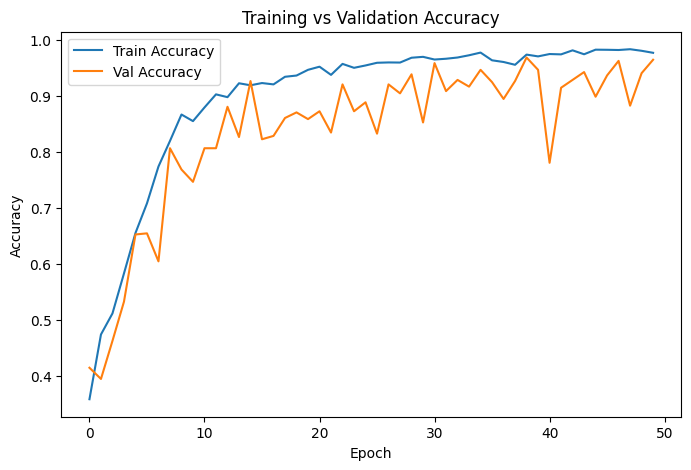

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Menampilkan grafik loss selama training

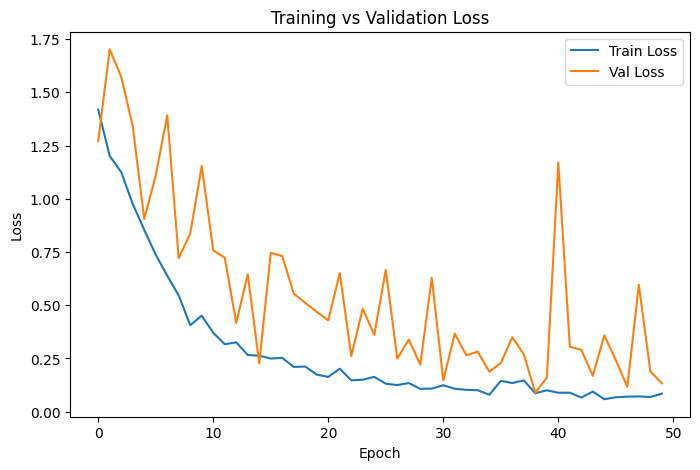

In [ ]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Menyimpan model

In [ ]:
model.save("hasil_1.keras")

In [ ]:
model.save("hasil_1.h5")

# Melakukan load model

In [ ]:
model = load_model('hasil_1.keras')

# Melakukan testing pada model

In [ ]:
y_pred = model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


In [ ]:
class_names = list(validation_data.class_indices.keys())

In [ ]:
y_true = validation_data.labels

# Menampilkan confusiion matriks

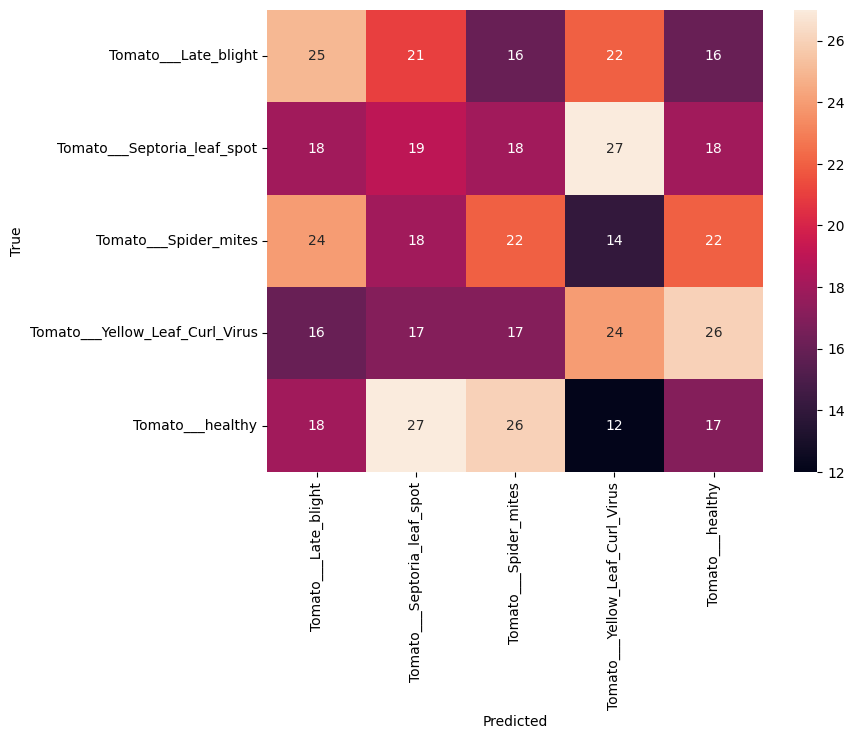

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Menampilkan classification report

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

                                 precision    recall  f1-score   support

           Tomato___Late_blight       0.25      0.25      0.25       100
    Tomato___Septoria_leaf_spot       0.19      0.19      0.19       100
          Tomato___Spider_mites       0.22      0.22      0.22       100
Tomato___Yellow_Leaf_Curl_Virus       0.24      0.24      0.24       100
               Tomato___healthy       0.17      0.17      0.17       100

                       accuracy                           0.21       500
                      macro avg       0.21      0.21      0.21       500
                   weighted avg       0.21      0.21      0.21       500

